## Contents

1. [Introduction](#intro)
2. [Create an Anomaly Detector](#ad)
1. [Create a Storage Account](#sa)
1. [Prepare your data](#data)
1. [Import modules and create an Anomaly Detector client](#import)
1. [Train a model](#train)
1. [Inference](#inference)
1. [List models](#list)
1. [Delete model](#delete)
1. [Visualization](#vis)

## 1. Introdution <a class="anchor" id="intro"></a>
This notebook shows how to use [Multivariate Anomaly Detection](https://docs.microsoft.com/en-us/azure/cognitive-services/anomaly-detector/overview-multivariate) SDK (the latest version for python - **3.0.0b6**) in Anomaly Detector service. Please follow the steps to try it out, you can either [join Teams Group](https://forms.office.com/Pages/ResponsePage.aspx?id=v4j5cvGGr0GRqy180BHbRxSkyhztUNZCtaivu8nmhd1UQ1VFRDA0V1dUMDJRMFhOTzFHQ1lDTVozWi4u) for any questions, or email us via AnomalyDetector@microsoft.com

## 2. Create an Anomaly Detector <a class="anchor" id="ad"></a>


* [Create an Azure subscription](https://azure.microsoft.com/free/cognitive-services) if you don't have one.
* [Create an Anomaly Detector resource](https://ms.portal.azure.com/#create/Microsoft.CognitiveServicesAnomalyDetector) and get your `endpoint` and `key`, paste in the cell below.

![](https://i.imgur.com/M7qATAY.png)

## 3. Create an Storage Account <a class="anchor" id="sa"></a>

1. [Create a Storage Account](https://ms.portal.azure.com/#create/Microsoft.StorageAccount-ARM).
1. Go to **Access Control(IAM)**, and select **+ADD** to **Add role assignment**.
3. Search role of **Storage Blob Data Reader**, **click on it** and then select **Next**.
4. Select assign access to **Managed identity**, and **Select Members**, then choose the anomaly detector resource that you created earlier, then select **Review + assign**.

![](https://i.imgur.com/dsTsuxI.gif)

## 4. Prepare your data <a class="anchor" id="data"></a>

### Download sample data
Multivariate Anomaly Detection supports two types of data schema for training and async inference: **`Multiple Tables`** and **`One Table`**. 

*  Download [One Table sample data](https://mvaddataset.blob.core.windows.net/public-sample-data/sample_data_5_3000.csv)
* Download [Multiple Tables sample data](https://mvaddataset.blob.core.windows.net/public-sample-data/sample_data_5_3000.zip) and unzip it.

### Upload data to Storage Account

1. Go to your Storage Account, select **Containers** and create a new container.
2. Select **Upload** to upload the folder *(for multiple tables)* or the CSV file *(for one table*) that you downloaded earlier.
3. Click on the data that you uploaded and copy the **Blob URL** to somewhere for further steps.

## 5. Import modules and create an Anomaly Detector client <a class="anchor" id="import"></a>

**Install** the anomaly detector SDK and storage packages using following codes ⬇️, and **import** packages.

In [35]:
# Install required packages. Use the following commands to install the anomaly detector SDK and required packages.
! pip install --upgrade azure-ai-anomalydetector
! pip install azure-storage-blob
! pip install azure-mgmt-storage

# Install optional packages to see interactive visualization in this Jupyter notebook.
! pip install plotly==5.5.0
! pip install notebook>=5.3 
! pip install ipywidgets>=7.5

In [36]:
import json
import os
import time
from datetime import datetime, timezone
import pandas as pd

from azure.ai.anomalydetector import AnomalyDetectorClient
from azure.core.credentials import AzureKeyCredential
from azure.core.exceptions import HttpResponseError
from azure.ai.anomalydetector.models import *

### Create an Anomaly Detector client

In [37]:
# The ENDPOINT should be like: https://mvad-sample.cognitiveservices.azure.com/anomalydetector/v1.1
ANOMALY_DETECTOR_ENDPOINT = "https://anomaly-detector-insurance-model.cognitiveservices.azure.com/"
SUBSCRIPTION_KEY = "afc4079baf494eb3a9a3ac076b58f4bd"

ad_client = AnomalyDetectorClient(ANOMALY_DETECTOR_ENDPOINT, AzureKeyCredential(SUBSCRIPTION_KEY))

## 6. Train a model <a class="anchor" id="train"></a>

In [38]:
train_body = ModelInfo(
        # The data source should be the Blob URL, something like: https://mvaddataset.blob.core.windows.net/sample-multitable/sample_data_5_3000.csv
        data_source="https://elg5164.blob.core.windows.net/elg5164/insurance-edited.csv",
        # start_time and end_time are optional. If you don't set them, the whole data will be used to train the model.
        start_time="2021-01-01T00:00:00Z",
        end_time="2021-01-02T09:00:00Z",
        # If your data is one CSV file, please set the dataSchema as `OneTable`, if your data is multiple CSV files in a folder, please set the dataSchema as `MultiTable`.
        data_schema="OneTable",
        # Use display_name to name your model.
        display_name="sample",
        # Sliding window size is optional. If you don't set it, the default value is 200.
        sliding_window=200,
        # align_policy is optional. If you don't set it, the default value is `AlignPolicy(align_mode=AlignMode.OUTER, fill_n_a_method=FillNAMethod.LINEAR, padding_value=0)`.
        align_policy=AlignPolicy(
            align_mode=AlignMode.OUTER,
            fill_n_a_method=FillNAMethod.LINEAR,
            padding_value=0,
        ),
    )

In [39]:
model = ad_client.train_multivariate_model(train_body)
model_id = model.model_id
print(f"Model is created with the modelId: {model_id}, please check the model status using next cell.😉")

Model is created with the modelId: 821eed80-d1ad-11ed-bc94-d65f80ec884f, please check the model status using next cell.😉


### Get model status 

☕️Training process might
take several minutes to hours (depending on the data size). Take a cup of coffee and come back then, and waiting for its status to be **READY**. You could also use the `epochId` to know the training progress.

In [40]:
model_status = ad_client.get_multivariate_model(model_id).model_info.status
print(f"Model status: {model_status}")

# Print the following line to get the epochId which could help you better know the status of model. There are 100 epochIds in total.
print(f"EpochId: {ad_client.get_multivariate_model(model_id).model_info.diagnostics_info.model_state}")

# Check error message if model status is ERROR/FAILED.
#ad_client.get_multivariate_model(model_id).model_info.errors[0].message

Model status: RUNNING
EpochId: {'epochIds': [10, 20, 30, 40], 'trainLosses': [1.3485820208277022, 1.2829891528402055, 1.264517162527357, 1.2566814933504378], 'validationLosses': [1.2566858927408855, 1.2386141690340908, 1.263209949840199, 1.2338912270285867], 'latenciesInSeconds': [1.7712948322296143, 1.6146953105926514, 1.7133817672729492, 1.5479323863983154]}


In [41]:
model_status = ad_client.get_multivariate_model(model_id).model_info.status
print(f"Model status: {model_status}")


Model status: RUNNING


## 7. Inference <a class="anchor" id="inference"></a>

There are two types of inference:
* Batch inference (asynchronous)
* Streaming inference (synchronous)

You could use the `Batch Inference API` for a long period of data validation or for a micro-batch task, which works in an asynchronous way together with the `Get Inference Results API`. If your case is more like real-time or near real-time, the `Streaming Inference API` might be a good choice for you since it will present the anomaly results immediately once you call this API and get every timestamp detected per call. 

### Trigger a batch inference

In [42]:
batch_inference_body = MultivariateBatchDetectionOptions(
        data_source="https://elg5164.blob.core.windows.net/elg5164/insurance-edited.csv",
        # The topContributorCount specify how many contributed variables you care about in the results, from 1 to 50.
        top_contributor_count=10,
        start_time="2021-01-01T00:18:00Z",
        end_time="2021-01-01T21:50:00Z",
    )

In [43]:
results = ad_client.detect_multivariate_batch_anomaly(model_id, batch_inference_body)
result_id = results.result_id
print(f"A batch inference is triggered with the resultId: {result_id}, please get the detection results using the next cell.")

A batch inference is triggered with the resultId: ec816bd2-d1b5-11ed-8275-6a9e5c6f24ea, please get the detection results using the next cell.


### Get batch inference results

☕️Inference process might
take several minutes (depending on the data size). Take a cup of coffee and come back then, and waiting for its status to be **READY**.

In [47]:
anomaly_results = ad_client.get_multivariate_batch_detection_result(result_id)
print(f"Batch inference status: {anomaly_results.summary}")

Batch inference status: {'status': 'READY', 'errors': [], 'variableStates': [{'variable': 'age', 'filledNARatio': 0.0, 'effectiveCount': 1293, 'firstTimestamp': '2021-01-01T00:18:00Z', 'lastTimestamp': '2021-01-01T21:50:00Z'}, {'variable': 'bmi', 'filledNARatio': 0.0, 'effectiveCount': 1293, 'firstTimestamp': '2021-01-01T00:18:00Z', 'lastTimestamp': '2021-01-01T21:50:00Z'}, {'variable': 'charges', 'filledNARatio': 0.0, 'effectiveCount': 1293, 'firstTimestamp': '2021-01-01T00:18:00Z', 'lastTimestamp': '2021-01-01T21:50:00Z'}, {'variable': 'children', 'filledNARatio': 0.0, 'effectiveCount': 1293, 'firstTimestamp': '2021-01-01T00:18:00Z', 'lastTimestamp': '2021-01-01T21:50:00Z'}, {'variable': 'sex', 'filledNARatio': 0.0, 'effectiveCount': 1293, 'firstTimestamp': '2021-01-01T00:18:00Z', 'lastTimestamp': '2021-01-01T21:50:00Z'}], 'setupInfo': {'dataSource': 'https://elg5164.blob.core.windows.net/elg5164/insurance-edited.csv', 'topContributorCount': 10, 'startTime': '2021-01-01T00:18:00Z', '

In [48]:
# anomaly_results
# for x in anomaly_results.results:
#     print(x)

anomaly_results_df = pd.DataFrame([{'timestamp': x['timestamp'], **x['value']} for x in anomaly_results.results])
anomaly_results_df

,timestamp,isAnomaly,severity,score,interpretation
0,2021-01-01T00:18:00Z,None,NaN,NaN,None
1,2021-01-01T00:19:00Z,None,NaN,NaN,None
2,2021-01-01T00:20:00Z,None,NaN,NaN,None
3,2021-01-01T00:21:00Z,None,NaN,NaN,None
4,2021-01-01T00:22:00Z,None,NaN,NaN,None
...,...,...,...,...,...
1288,2021-01-01T21:46:00Z,True,0.453722,0.779622,"[{'variable': 'sex', 'contributionScore': 0.30..."
1289,2021-01-01T21:47:00Z,True,0.492337,0.845974,"[{'variable': 'children', 'contributionScore':..."
1290,2021-01-01T21:48:00Z,True,0.481718,0.827728,"[{'variable': 'sex', 'contributionScore': 0.28..."
1291,2021-01-01T21:49:00Z,False,0.000000,0.454954,[]


### Streaming Inference

Every time you trigger a streaming inference, you will get one timestamp detected.

In [49]:
with open("./insurance.json", "r") as f:
    sample_input = json.load(f)

variables = []
for item in sample_input["variables"]:
    variables.append(
        VariableValues(
            variable=item["variable"],
            timestamps=item["timestamp"],
            values=item["values"],
        )
    )

last_inference_body = MultivariateLastDetectionOptions(
    variables=variables,
    top_contributor_count=10,
)

In [50]:
streaming_inference_results = ad_client.detect_multivariate_last_anomaly(model_id, last_inference_body)
streaming_inference_results

{'variableStates': [{'variable': 'age', 'filledNARatio': 0.0, 'effectiveCount': 1, 'firstTimestamp': '2021-01-01T22:17:00Z', 'lastTimestamp': '2021-01-01T22:17:00Z'}, {'variable': 'bmi', 'filledNARatio': 0.0, 'effectiveCount': 1, 'firstTimestamp': '2021-01-01T22:17:00Z', 'lastTimestamp': '2021-01-01T22:17:00Z'}, {'variable': 'charges', 'filledNARatio': 0.0, 'effectiveCount': 1, 'firstTimestamp': '2021-01-01T22:17:00Z', 'lastTimestamp': '2021-01-01T22:17:00Z'}, {'variable': 'children', 'filledNARatio': 0.0, 'effectiveCount': 1, 'firstTimestamp': '2021-01-01T22:17:00Z', 'lastTimestamp': '2021-01-01T22:17:00Z'}, {'variable': 'sex', 'filledNARatio': 0.0, 'effectiveCount': 1, 'firstTimestamp': '2021-01-01T22:17:00Z', 'lastTimestamp': '2021-01-01T22:17:00Z'}, {'variable': 'smoker', 'filledNARatio': 0.0, 'effectiveCount': 1, 'firstTimestamp': '2021-01-01T22:17:00Z', 'lastTimestamp': '2021-01-01T22:17:00Z'}], 'results': [{'timestamp': '2021-01-01T22:17:00Z', 'value': {'isAnomaly': True, 'sever

## 8. List models <a class="anchor" id="list"></a>
You could check the status of your model and your model list. The `currentCount` means how many model you've created in your Anomaly Detector resource, and the `maxCount` means the limitation of your model number in your Anomaly Detector resource.

In [51]:
models = list(ad_client.list_multivariate_models(skip=0,top=10))
models_df = pd.DataFrame([{'modelId': x['modelId'], **x['modelInfo']} for x in models])
models_df

,modelId,dataSource,dataSchema,startTime,endTime,displayName,slidingWindow,alignPolicy,status,errors,diagnosticsInfo
0,821eed80-d1ad-11ed-bc94-d65f80ec884f,https://elg5164.blob.core.windows.net/elg5164/...,OneTable,2021-01-01T00:00:00Z,2021-01-02T09:00:00Z,sample,200,"{'alignMode': 'Outer', 'fillNAMethod': 'Linear...",READY,[],"{'modelState': {'epochIds': [10, 20, 30, 40, 5..."
1,d8e248e0-d05b-11ed-942b-d65f80ec884f,https://elg5164.blob.core.windows.net/elg5164/...,OneTable,2021-01-01T00:00:00Z,2021-01-02T09:00:00Z,sample,200,"{'alignMode': 'Outer', 'fillNAMethod': 'Linear...",FAILED,"[{'code': 'FileColumnsNotExist', 'message': 'C...","{'modelState': {'epochIds': [], 'trainLosses':..."
2,7478c6e6-d050-11ed-bc94-d65f80ec884f,https://elg5164.blob.core.windows.net/elg5164/...,OneTable,2021-01-01T00:00:00Z,2021-01-02T09:00:00Z,sample,200,"{'alignMode': 'Outer', 'fillNAMethod': 'Linear...",READY,[],"{'modelState': {'epochIds': [10, 20, 30, 40, 5..."
3,42547196-d04c-11ed-bc94-d65f80ec884f,https://elg5164.blob.core.windows.net/elg5164/...,OneTable,2021-01-01T00:00:00Z,2021-01-02T09:00:00Z,sample,200,"{'alignMode': 'Outer', 'fillNAMethod': 'Linear...",READY,[],"{'modelState': {'epochIds': [10, 20, 30, 40, 5..."
4,51ac0c0e-d04b-11ed-9a3b-0e66fc11ae73,https://elg5164.blob.core.windows.net/elg5164/...,OneTable,2021-01-01T00:00:00Z,2021-01-02T09:00:00Z,sample,200,"{'alignMode': 'Outer', 'fillNAMethod': 'Linear...",READY,[],"{'modelState': {'epochIds': [10, 20, 30, 40, 5..."
5,e9fac59e-d047-11ed-99cb-86ea07752cdd,https://elg5164.blob.core.windows.net/elg5164/...,OneTable,2021-01-01T00:00:00Z,2021-01-02T09:00:00Z,sample,200,"{'alignMode': 'Outer', 'fillNAMethod': 'Linear...",READY,[],"{'modelState': {'epochIds': [10, 20, 30, 40, 5..."
6,3011900c-d044-11ed-a10d-86ea07752cdd,https://elg5164.blob.core.windows.net/elg5164/...,OneTable,2021-01-01T00:00:00Z,2021-01-02T09:00:00Z,sample,200,"{'alignMode': 'Outer', 'fillNAMethod': 'Linear...",READY,[],"{'modelState': {'epochIds': [10, 20, 30, 40, 5..."
7,e8161814-d042-11ed-99cb-86ea07752cdd,https://elg5164.blob.core.windows.net/elg5164/...,OneTable,2021-01-01T00:00:00Z,2021-01-02T09:00:00Z,sample,200,"{'alignMode': 'Outer', 'fillNAMethod': 'Linear...",READY,[],"{'modelState': {'epochIds': [10, 20, 30, 40, 5..."
8,8151d1a8-d01b-11ed-94f5-420df20daa66,https://elg5164.blob.core.windows.net/elg5164/...,OneTable,2021-01-01T00:00:00Z,2021-01-02T09:00:00Z,sample,200,"{'alignMode': 'Outer', 'fillNAMethod': 'Linear...",FAILED,"[{'code': 'VariableParseError', 'message': 'Va...","{'modelState': {'epochIds': [], 'trainLosses':..."
9,f432fc30-d019-11ed-99cb-86ea07752cdd,https://elg5164.blob.core.windows.net/elg5164/...,OneTable,2021-01-01T00:00:00Z,2021-01-02T09:00:00Z,sample,200,"{'alignMode': 'Outer', 'fillNAMethod': 'Linear...",FAILED,"[{'code': 'FileColumnsNotExist', 'message': 'C...","{'modelState': {'epochIds': [], 'trainLosses':..."


## 9. Delete model <a class="anchor" id="delete"></a>

In [52]:
ad_client.delete_multivariate_model(model_id)

## 10. Visualization <a class="anchor" id="vis"></a>

In [53]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

raw_data=pd.read_csv('./insurance-edited.csv')
df_merge=pd.merge(anomaly_results_df,raw_data, on="timestamp")
df_merge

,timestamp,isAnomaly,severity,score,interpretation,age,sex,bmi,children,smoker,charges
0,2021-01-01T00:18:00Z,None,NaN,NaN,None,56,0,40.300,0,0,10602.38500
1,2021-01-01T00:19:00Z,None,NaN,NaN,None,30,0,35.300,0,1,36837.46700
2,2021-01-01T00:20:00Z,None,NaN,NaN,None,60,1,36.005,0,0,13228.84695
3,2021-01-01T00:21:00Z,None,NaN,NaN,None,30,1,32.400,1,0,4149.73600
4,2021-01-01T00:22:00Z,None,NaN,NaN,None,18,0,34.100,0,0,1137.01100
...,...,...,...,...,...,...,...,...,...,...,...
1288,2021-01-01T21:46:00Z,True,0.453722,0.779622,"[{'variable': 'sex', 'contributionScore': 0.30...",29,1,21.850,0,1,16115.30450
1289,2021-01-01T21:47:00Z,True,0.492337,0.845974,"[{'variable': 'children', 'contributionScore':...",32,0,28.120,4,1,21472.47880
1290,2021-01-01T21:48:00Z,True,0.481718,0.827728,"[{'variable': 'sex', 'contributionScore': 0.28...",25,1,30.200,0,1,33900.65300
1291,2021-01-01T21:49:00Z,False,0.000000,0.454954,[],41,0,32.200,2,0,6875.96100


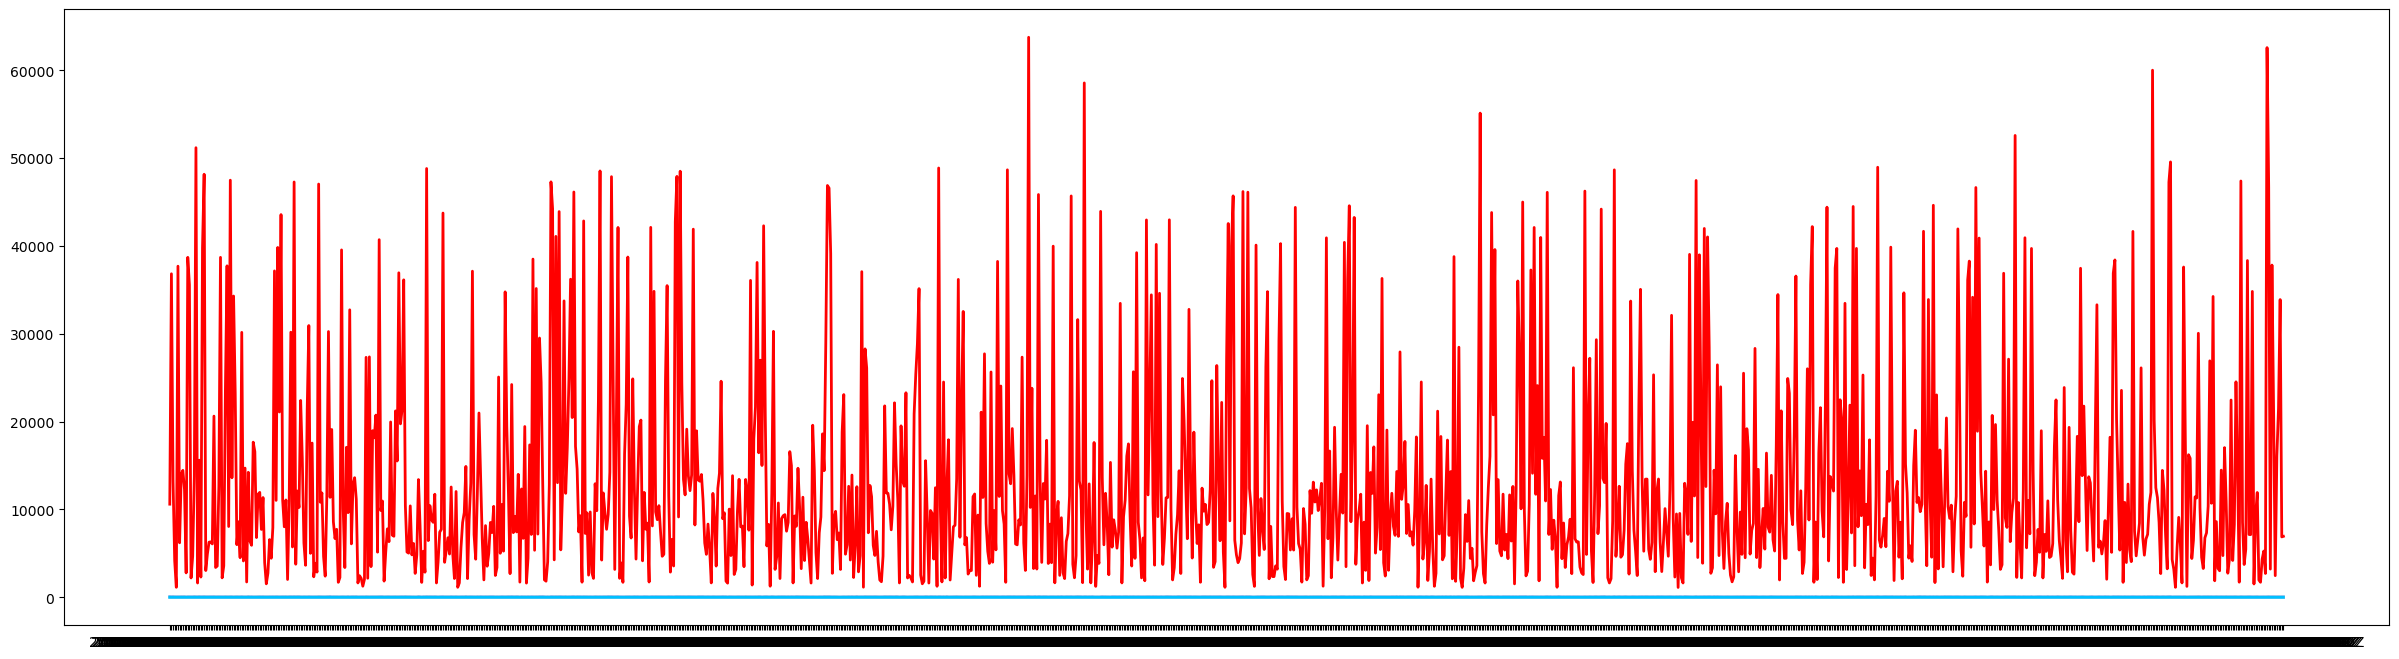

In [54]:
####### Main Figure #######
plt.figure(figsize=(30,8))
plt.plot(df_merge['timestamp'],df_merge['age'], color='lightsteelblue', linestyle='solid', linewidth=2, label='age')
plt.plot(df_merge['timestamp'],df_merge['sex'], color='powderblue', linestyle='solid', linewidth=2, label='sex')
plt.plot(df_merge['timestamp'],df_merge['bmi'], color='cornflowerblue', linestyle='solid', linewidth=2, label='bmi')
plt.plot(df_merge['timestamp'],df_merge['children'], color='lightblue', linestyle='solid', linewidth=2, label='children')
plt.plot(df_merge['timestamp'],df_merge['smoker'], color='deepskyblue', linestyle='solid', linewidth=2, label='smoker')
plt.plot(df_merge['timestamp'],df_merge['charges'], color='red', linestyle='solid', linewidth=2, label='charges')

ConversionError: Failed to convert value(s) to axis units: (array([], dtype=int64),)

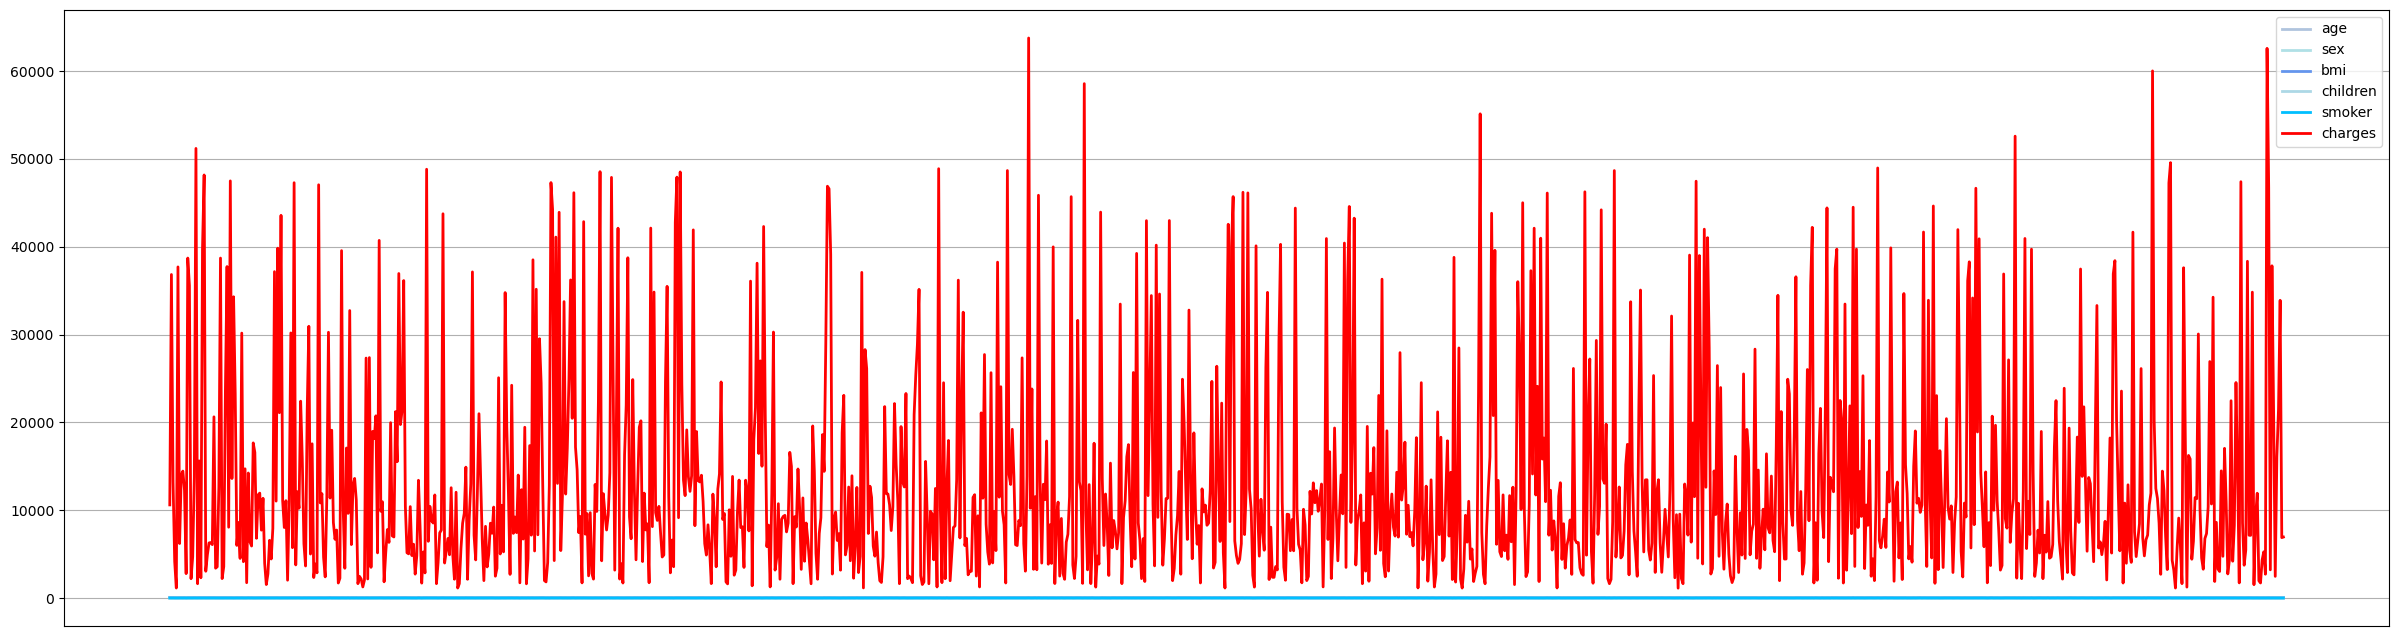

In [55]:
# You could use this parameter to sift out the anomalies, the less this number is, the more anomalies will be marked out.
minSeverity = 0.2

# Only presents first 100 rows to see clearer graph.
df = df_merge.iloc[:100]

####### Main Figure #######
plt.figure(figsize=(30,8))
plt.plot(df_merge['timestamp'],df_merge['age'], color='lightsteelblue', linestyle='solid', linewidth=2, label='age')
plt.plot(df_merge['timestamp'],df_merge['sex'], color='powderblue', linestyle='solid', linewidth=2, label='sex')
plt.plot(df_merge['timestamp'],df_merge['bmi'], color='cornflowerblue', linestyle='solid', linewidth=2, label='bmi')
plt.plot(df_merge['timestamp'],df_merge['children'], color='lightblue', linestyle='solid', linewidth=2, label='children')
plt.plot(df_merge['timestamp'],df_merge['smoker'], color='deepskyblue', linestyle='solid', linewidth=2, label='smoker')
plt.plot(df_merge['timestamp'],df_merge['charges'], color='red', linestyle='solid', linewidth=2, label='charges')

plt.grid(axis='y')
plt.tick_params(axis='x',which='both',bottom=False,labelbottom=False)
plt.legend()

anoms = list(df["severity"] >= minSeverity)
_, _, ymin, ymax = plt.axis()
plt.vlines(np.where(anoms), ymin=ymin , ymax=ymax , color='r', alpha=1,linewidth=3)

plt.legend()
plt.title('A plot of the values from the variables with the detected anomalies highlighted in red.')
plt.show()


####### Severity Figure #######
plt.figure(figsize=(30,8))
plt.tick_params(axis='x',which='both',bottom=False,labelbottom=False)
plt.plot(df['timestamp'],df['severity'], color='black', linestyle='solid', linewidth=2, label='Severity')
plt.plot(df['timestamp'],df['score'], color='lightgrey', linestyle='solid', linewidth=2, label='Score')
plt.plot(df['timestamp'],[minSeverity]*len(df['severity']), color='red', linestyle='dotted', linewidth=1, label='minSeverity')
plt.grid(axis='y')
plt.legend()
plt.ylim((0,1))
plt.title("Severity and Score of the detected anomalies")
plt.show()

In [56]:
# Display only the anomalous timestamps.
df_anomaly = df_merge[df_merge['isAnomaly']== True]
df_anomaly

,timestamp,isAnomaly,severity,score,interpretation,age,sex,bmi,children,smoker,charges
185,2021-01-01T03:23:00Z,True,0.449010,0.771525,"[{'variable': 'smoker', 'contributionScore': 0...",27,1,36.08,0,1,37133.89820
205,2021-01-01T03:43:00Z,True,0.518752,0.891361,"[{'variable': 'sex', 'contributionScore': 0.26...",19,0,34.80,0,1,34779.61500
209,2021-01-01T03:47:00Z,True,0.450614,0.774282,"[{'variable': 'sex', 'contributionScore': 0.30...",58,1,41.91,0,0,24227.33724
214,2021-01-01T03:52:00Z,True,0.472935,0.812635,"[{'variable': 'age', 'contributionScore': 0.23...",19,1,17.80,0,0,1727.78500
220,2021-01-01T03:58:00Z,True,0.423049,0.726917,"[{'variable': 'sex', 'contributionScore': 0.32...",19,0,29.07,0,1,17352.68030
...,...,...,...,...,...,...,...,...,...,...,...
1284,2021-01-01T21:42:00Z,True,0.415988,0.714785,"[{'variable': 'sex', 'contributionScore': 0.33...",25,1,20.80,1,0,3208.78700
1285,2021-01-01T21:43:00Z,True,0.440199,0.756385,"[{'variable': 'smoker', 'contributionScore': 0...",43,0,27.80,0,1,37829.72420
1288,2021-01-01T21:46:00Z,True,0.453722,0.779622,"[{'variable': 'sex', 'contributionScore': 0.30...",29,1,21.85,0,1,16115.30450
1289,2021-01-01T21:47:00Z,True,0.492337,0.845974,"[{'variable': 'children', 'contributionScore':...",32,0,28.12,4,1,21472.47880


In [57]:
df_anomaly.interpretation[205]

[{'variable': 'sex',
  'contributionScore': 0.2677367792558216,
  'correlationChanges': {'changedVariables': ['sex', 'children']}},
 {'variable': 'smoker',
  'contributionScore': 0.2677367792558216,
  'correlationChanges': {'changedVariables': ['sex', 'bmi']}},
 {'variable': 'age',
  'contributionScore': 0.2050588846081072,
  'correlationChanges': {'changedVariables': ['sex', 'children']}},
 {'variable': 'charges',
  'contributionScore': 0.12738012491415526,
  'correlationChanges': {'changedVariables': ['sex']}},
 {'variable': 'children',
  'contributionScore': 0.08674356976198085,
  'correlationChanges': {'changedVariables': ['sex']}},
 {'variable': 'bmi',
  'contributionScore': 0.0453438622041136,
  'correlationChanges': {'changedVariables': ['sex']}}]

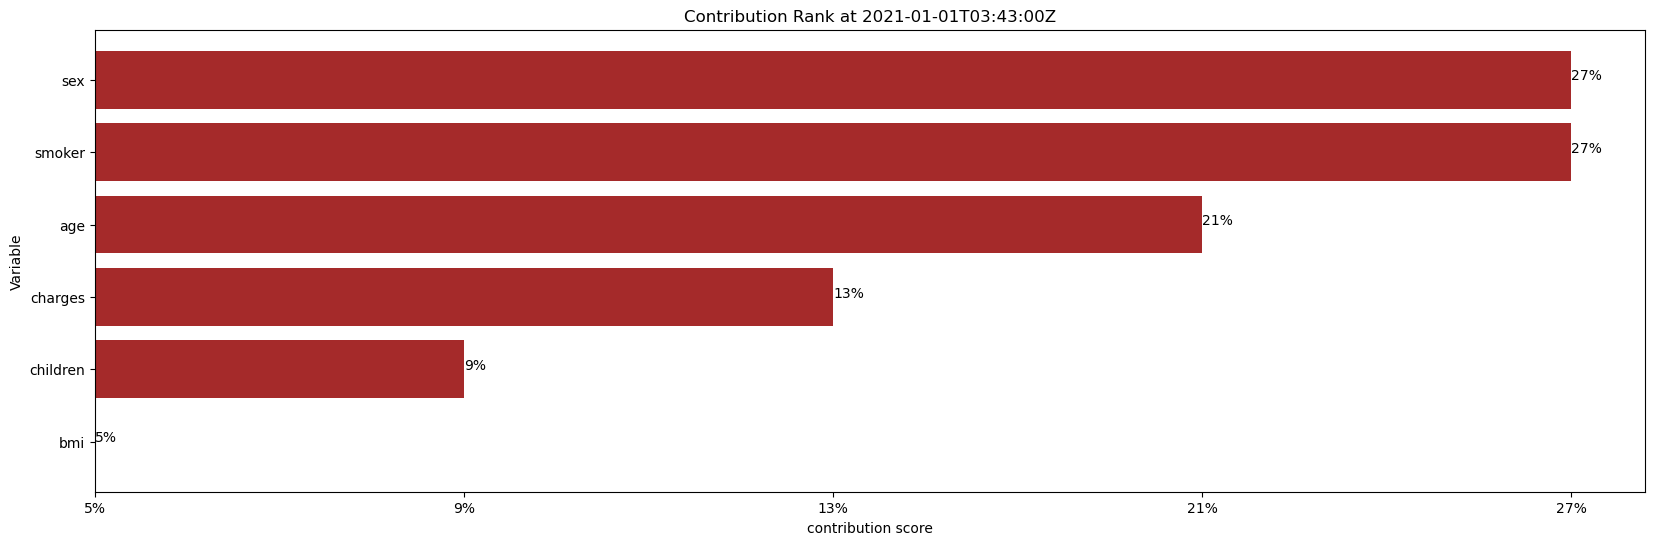

The last column indicates the correlated variables with the first column variable, whose correlations caused the anomaly.


,variable,contributionScore,correlationChanges.changedVariables
0,sex,0.267737,"[sex, children]"
1,smoker,0.267737,"[sex, bmi]"
2,age,0.205059,"[sex, children]"
3,charges,0.127380,[sex]
4,children,0.086744,[sex]
5,bmi,0.045344,[sex]


In [58]:
from tkinter.font import BOLD
from turtle import color


anomaly_index = 1
d = df_anomaly.iloc[anomaly_index]['interpretation'][::-1]
timestamp = df_anomaly.iloc[anomaly_index]['timestamp']
correlatedVar = df_anomaly.iloc[anomaly_index]['interpretation']

x=[item.get('variable') for item in d]
y=[item.get('contributionScore') for item in d]
Z=[item.get('correlationChanges') for item in d]

l=[]
for i in y:
    i =  "%.f%%" % (i * 100)
    l.append(i)

plt.figure(figsize=(20,6))


plt.barh(x, l,color="brown",alpha=1)

for index, value in enumerate(l):
    plt.text(value, index,str(value) )

# setting label of y-axis
plt.ylabel("Variable")

# setting label of x-axis
plt.xlabel("contribution score")
plt.title("Contribution Rank at "+timestamp)

plt.show()
print("The last column indicates the correlated variables with the first column variable, whose correlations caused the anomaly.")
pd.json_normalize(correlatedVar)

In [59]:
pip install opencensus-ext-azure

Note: you may need to restart the kernel to use updated packages.


In [60]:
import logging
from opencensus.ext.azure.log_exporter import AzureLogHandler

logger = logging.getLogger(__name__)

#manually pass in the connection_string
logger.addHandler(AzureLogHandler(connection_string="InstrumentationKey=a06ed340-b358-4634-823a-5b91beec8467;IngestionEndpoint=https://eastus2-3.in.applicationinsights.azure.com/;LiveEndpoint=https://eastus2.livediagnostics.monitor.azure.com/"))

   
anomalyList = df_anomaly.values.tolist()
i = 0;
for entry in anomalyList:
    logger.warning(f"Anomaly Interpretation- {entry[4]}")
    i += 1
    if(i>10):
        break
            